# Load DeepLSD and predict lines

In [2]:

import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5'
bump_normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5'
position_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.position.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])
with h5py.File(bump_normal_path, 'r') as f:
    bump_normal_map = np.array(f['dataset'])

with h5py.File(position_path, "r") as f:
        world_coordinates = np.array(f["dataset"])  

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
bump_normal_map = bump_normal_map.astype(np.float32)
world_coordinates = world_coordinates.astype(np.float32)

# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Visualize world_coordinates as Voxels

Running Example 1 (Path Exists):


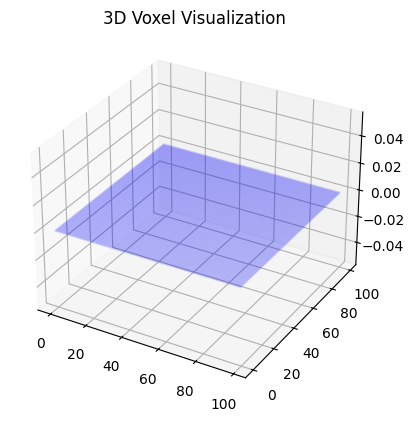

Example 1: Path found with length: 161


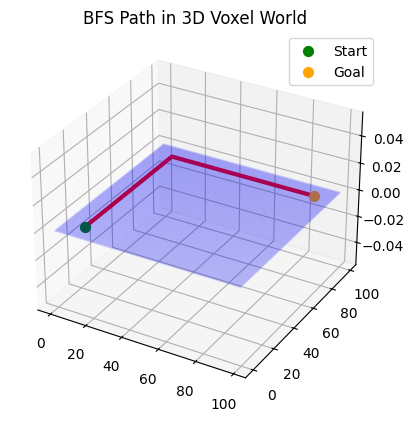


Running Example 2 (No Path Exists):


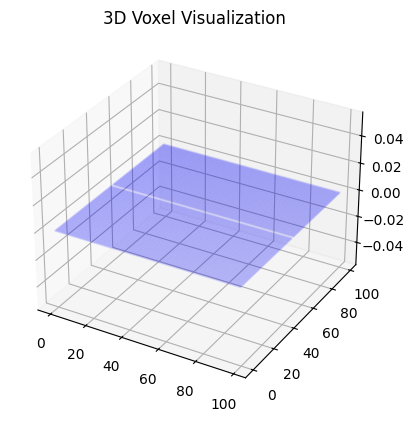

Example 2: No path found between (10, 10) and (90, 90)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from collections import deque

# -------------------------------
# Visualization of the voxel cloud
# -------------------------------
def visualize_voxels(world_coordinates):
    """
    Create a 3D scatter plot of the voxels.
    Existing voxels are colored (here blue) and non-existing ones (with NaN) are omitted.
    """
    # Create a mask for valid (existing) voxels.
    mask = ~np.isnan(world_coordinates).any(axis=-1)
    voxels = world_coordinates[mask]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Scatter plot: adjust marker size (s) and alpha for visibility
    ax.scatter(voxels[:, 0], voxels[:, 1], voxels[:, 2],
               c='blue', marker='o', s=1, alpha=0.1)
    ax.set_title("3D Voxel Visualization")
    plt.show()

# -------------------------------
# 3D neighborhood check function
# -------------------------------
def is_adjacent_3d(coord1, coord2, threshold=1.5):
    """
    Check if two 3D coordinates (voxels) are "neighbors".
    For example, if the Euclidean distance between them is less than the threshold.
    
    Adjust the threshold based on the voxel grid spacing.
    """
    # Skip if either coordinate is not valid.
    if np.isnan(coord1).any() or np.isnan(coord2).any():
        return False
    return np.linalg.norm(coord1 - coord2) < threshold

# -------------------------------
# BFS on the 2D grid with 3D connectivity condition
# -------------------------------
def bfs_path(world_coordinates, start, goal, threshold=1.5):
    """
    Find a path from start to goal in the 2D image grid,
    moving only to 4-connected neighbors that are also adjacent in 3D.
    
    Parameters:
      world_coordinates: numpy array of shape (H, W, 3)
      start, goal: tuples of (row, col) in the image grid.
      threshold: maximum Euclidean distance between 3D coordinates to be considered neighbors.
    
    Returns:
      A list of (row, col) tuples representing the path, or None if no path is found.
    """
    H, W, _ = world_coordinates.shape
    visited = np.zeros((H, W), dtype=bool)
    parent = np.empty((H, W), dtype=object)
    
    # Initialize BFS with the start pixel.
    queue = deque()
    queue.append(start)
    visited[start] = True
    parent[start] = None
    
    # Define 4-connected directions: up, down, left, right.
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while queue:
        current = queue.popleft()
        if current == goal:
            break
        i, j = current
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < H and 0 <= nj < W and not visited[ni, nj]:
                # Only move to neighbor if the 3D coordinates are adjacent.
                if is_adjacent_3d(world_coordinates[i, j], world_coordinates[ni, nj], threshold):
                    visited[ni, nj] = True
                    parent[ni, nj] = current
                    queue.append((ni, nj))
                    
    # If goal was not reached, return None.
    if not visited[goal]:
        return None
    
    # Reconstruct the path from goal to start.
    path = []
    current = goal
    while current is not None:
        path.append(current)
        current = parent[current]
    path.reverse()
    return path

# -------------------------------
# Visualize the BFS path in 3D
# -------------------------------
def visualize_path(world_coordinates, path):
    """
    Visualize the full voxel cloud and overlay the BFS path (in red)
    through the 3D coordinates corresponding to the 2D path.
    The start is marked in green and the goal in orange.
    """
    # Convert the 2D path indices to 3D coordinates.
    path_coords = np.array([world_coordinates[i, j] for (i, j) in path])
    
    # Prepare the voxel scatter plot.
    mask = ~np.isnan(world_coordinates).any(axis=-1)
    voxels = world_coordinates[mask]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all voxels (semi-transparent for context).
    ax.scatter(voxels[:, 0], voxels[:, 1], voxels[:, 2],
               c='blue', marker='o', s=1, alpha=0.1)
    # Overlay the BFS path as a red line.
    ax.plot(path_coords[:, 0], path_coords[:, 1], path_coords[:, 2],
            c='red', linewidth=3)
    # Mark the start and goal points.
    ax.scatter(path_coords[0, 0], path_coords[0, 1], path_coords[0, 2],
               c='green', s=50, label='Start')
    ax.scatter(path_coords[-1, 0], path_coords[-1, 1], path_coords[-1, 2],
               c='orange', s=50, label='Goal')
    ax.set_title("BFS Path in 3D Voxel World")
    ax.legend()
    plt.show()

# -------------------------------
# Example usage:
# -------------------------------
# -------------------------------
# Example 1: Path Exists
# -------------------------------
def example_path_exists():
    # Create a grid (100 x 100) with a flat 3D mapping (z=0).
    H, W = 100, 100
    x = np.linspace(0, W-1, W)
    y = np.linspace(0, H-1, H)
    xx, yy = np.meshgrid(x, y)
    world_coordinates_demo = np.stack([xx, yy, np.zeros_like(xx)], axis=-1).astype(np.float32)
    
    # Remove a block in the middle (but not spanning the entire width)
    world_coordinates[40:60, 40:60, :] = np.nan
    visualize_voxels(world_coordinates_demo)
    start = (10, 10)
    goal = (90, 90)
    path = bfs_path(world_coordinates_demo, start, goal, threshold=1.5)
    
    if path is not None:
        print("Example 1: Path found with length:", len(path))
        visualize_path(world_coordinates_demo, path)
    else:
        print("Example 1: No path found between", start, "and", goal)

# -------------------------------
# Example 2: No Path Exists
# -------------------------------
def example_no_path():
    # Create the same grid as before.
    H, W = 100, 100
    x = np.linspace(0, W-1, W)
    y = np.linspace(0, H-1, H)
    xx, yy = np.meshgrid(x, y)
    world_coordinates_demo = np.stack([xx, yy, np.zeros_like(xx)], axis=-1).astype(np.float32)
    
    # Create a complete horizontal barrier by removing an entire row of voxels.
    # This disconnects the top and bottom halves of the grid.
    world_coordinates_demo[50, :, :] = np.nan
    visualize_voxels(world_coordinates_demo)
    start = (10, 10)
    goal = (90, 90)
    path = bfs_path(world_coordinates_demo, start, goal, threshold=1.5)
    
    if path is not None:
        print("Example 2: Path found with length:", len(path))
        visualize_path(world_coordinates_demo, path)
    else:
        print("Example 2: No path found between", start, "and", goal)


if __name__ == '__main__':
    print("Running Example 1 (Path Exists):")
    example_path_exists()
    
    print("\nRunning Example 2 (No Path Exists):")
    example_no_path()


# Find coplanar lines for each line by computing the plane using normals and 3d coordinates given by Hypersim

In [3]:

def compute_plane(point, normal):
    """Compute plane equation: ax + by + cz + d = 0."""
    a, b, c = normal
    x0, y0, z0 = point
    d = - (a * x0 + b * y0 + c * z0)
    return (a, b, c, d)


def point_on_plane(plane, point, threshold=1e-3):
    """Check if a point lies on the plane."""
    a, b, c, d = plane
    distance = abs(a * point[0] + b * point[1] + c * point[2] + d)
    return distance < threshold

def are_lines_coplanar(line1_points, line1_normals, line2_points, line2_normals, normal_threshold=0.97):
    """
    Check if two lines are coplanar using their points and normals, symmetrically.
    """
    # First check using line1 to define the plane
    plane1 = compute_plane(line1_points[0], line1_normals[0])
    
    for point in np.vstack([line1_points, line2_points]):
        if not point_on_plane(plane1, point, 0.1):
            return False
    
    # Now check using line2 to define the plane
    plane2 = compute_plane(line2_points[0], line2_normals[0])
    
    for point in np.vstack([line1_points, line2_points]):
        if not point_on_plane(plane2, point, 0.1):
            return False
        
    avg_normal_line1 = np.mean(line1_normals, axis=0)
    avg_normal_line2 = np.mean(line2_normals, axis=0)
    dot_product = np.dot(avg_normal_line1, avg_normal_line2)
    


    
    return dot_product > normal_threshold and dot_product > normal_threshold


def get_line_pixels(line, maps):
    """
    Get all pixel coordinates along a line using cv2.line.

    """
    # Extract line endpoints
    x1, y1 = int(line[0][0]), int(line[0][1])
    x2, y2 = int(line[1][0]), int(line[1][1])
    
    # Create a blank image of the same size as the maps
    height, width = maps.shape[:2]
    blank_image = np.zeros((height, width), dtype=np.uint8)
    
    # Draw the line on the blank image
    cv2.line(blank_image, (x1, y1), (x2, y2), color=255, thickness=1)
    
    # Extract pixel coordinates of the line
    y_coords, x_coords = np.where(blank_image == 255)
    
    # Return a list of (x, y) tuples
    return list(zip(x_coords, y_coords))

def find_coplanar_lines_using_planes(lines, normal_map, world_coordinates):
    """
    Find coplanar lines using plane equations derived from points and normals.
    """
    coplanar_pairs = []
    coplanar_pairs = []
    coplanars = [False] * len(pred_lines)
    coplanar_dict = []
    for i in range(len(pred_lines)):
        coplanar_dict.append([False] * len(pred_lines))

    height, width = depth_map.shape  
    
    # Precompute sampled points and normals for all lines
    line_data = []
    for line in lines:

        pixel_coords = get_line_pixels(line, depth_map)

        points = []
        normals = []
        for x, y in pixel_coords:
            x_clip = int(np.clip(x, 0, width - 1))
            y_clip = int(np.clip(y, 0, height - 1))
            points.append(world_coordinates[y_clip, x_clip])
            normals.append(normal_map[y_clip, x_clip])
        line_data.append({
            "points": np.array(points),
            "normals": np.array(normals),
        })
    
    # Compare all pairs of lines
    for i in range(len(lines)):
        for j in range(len(lines)):
            line1 = line_data[i]
            line2 = line_data[j]
            
            if are_lines_coplanar(
                line1["points"], line1["normals"],
                line2["points"], line2["normals"]
            ) and not i == j:
                coplanar_pairs.append((i, j))
                coplanars[i] = True
                coplanars[j] = True
                coplanar_dict[i][j] = True
    
    return coplanar_pairs, coplanar_dict, coplanars


coplanar_pairs, coplanar_dict, coplanars = find_coplanar_lines_using_planes(pred_lines, normal_map, world_coordinates)
print("Coplanar line pairs:", coplanar_pairs)

Coplanar line pairs: [(0, 9), (0, 25), (0, 126), (0, 172), (0, 239), (0, 263), (0, 290), (0, 300), (0, 322), (0, 323), (8, 15), (8, 21), (8, 62), (8, 69), (8, 149), (8, 158), (8, 171), (8, 179), (8, 190), (8, 194), (8, 195), (8, 197), (8, 205), (8, 215), (8, 242), (8, 259), (8, 283), (8, 310), (8, 312), (8, 317), (8, 320), (8, 340), (8, 341), (8, 345), (8, 356), (8, 358), (8, 369), (8, 385), (9, 0), (9, 25), (9, 126), (9, 172), (9, 239), (9, 263), (9, 290), (9, 300), (9, 322), (9, 323), (11, 16), (11, 37), (11, 40), (11, 46), (11, 83), (11, 84), (11, 92), (11, 95), (11, 98), (11, 112), (11, 136), (11, 137), (11, 151), (11, 213), (11, 231), (11, 232), (11, 270), (11, 271), (11, 354), (15, 8), (15, 21), (15, 69), (15, 149), (15, 171), (15, 179), (15, 190), (15, 194), (15, 195), (15, 197), (15, 205), (15, 215), (15, 259), (15, 283), (15, 310), (15, 312), (15, 317), (15, 320), (15, 340), (15, 341), (15, 345), (15, 356), (15, 358), (15, 369), (15, 385), (16, 11), (16, 37), (16, 40), (16, 46

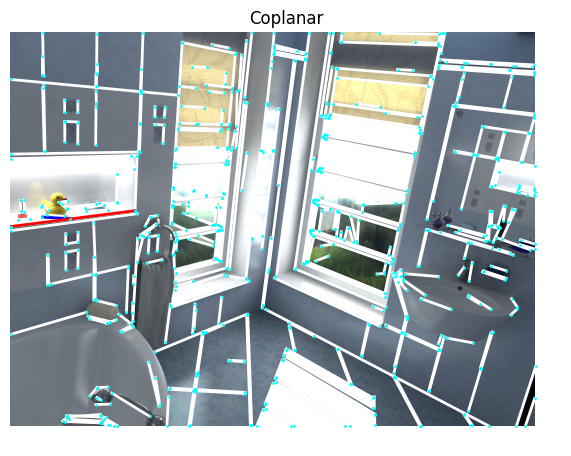

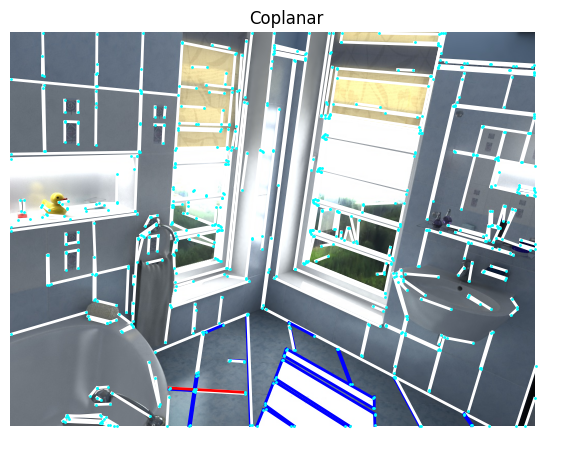

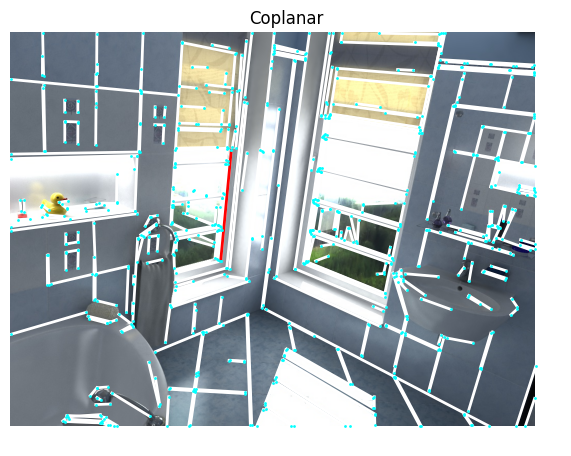

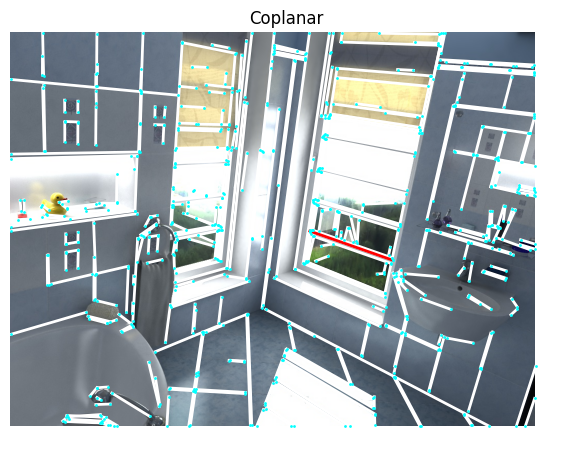

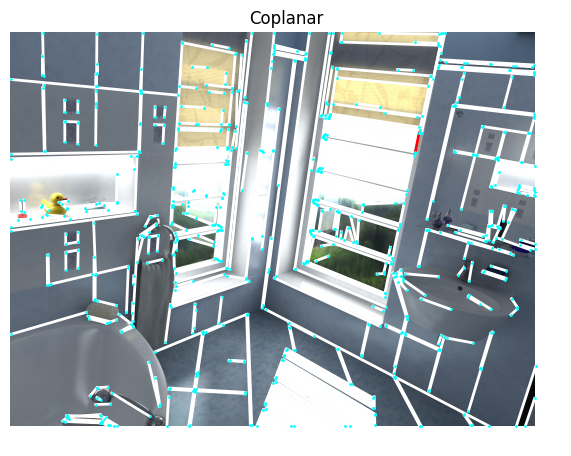

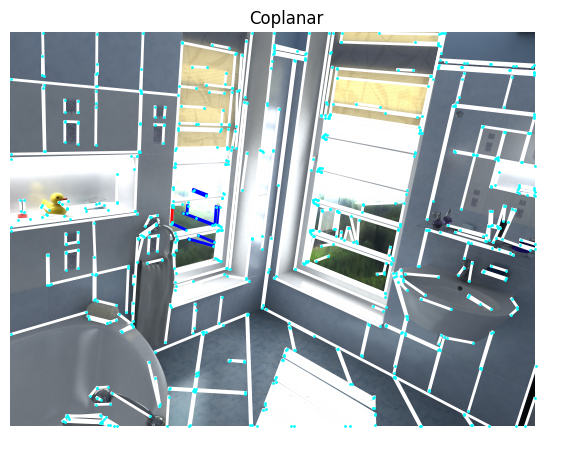

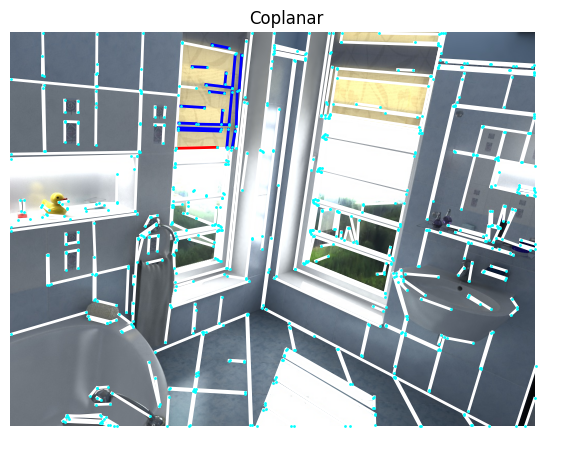

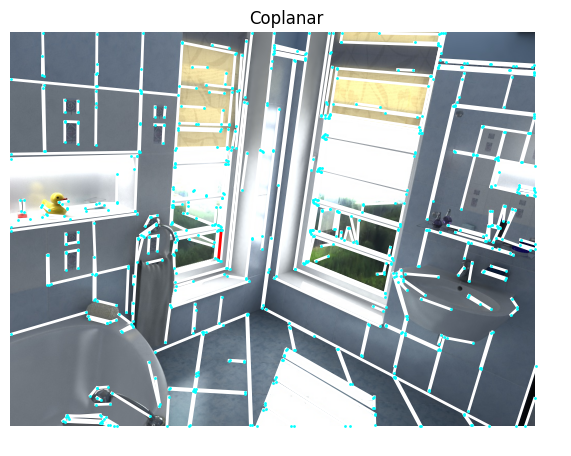

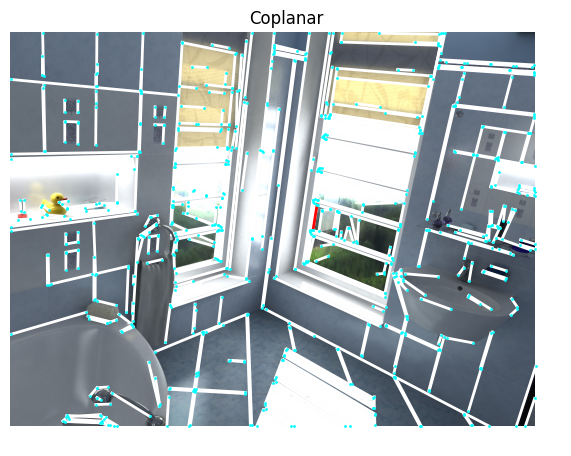

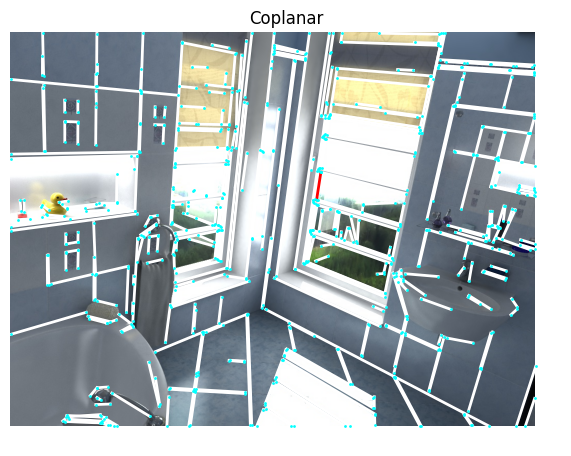

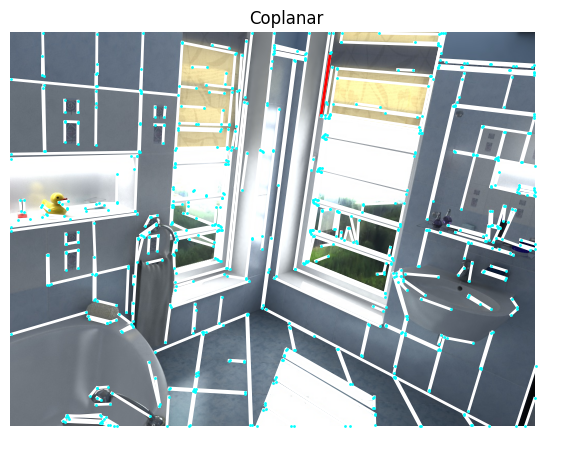

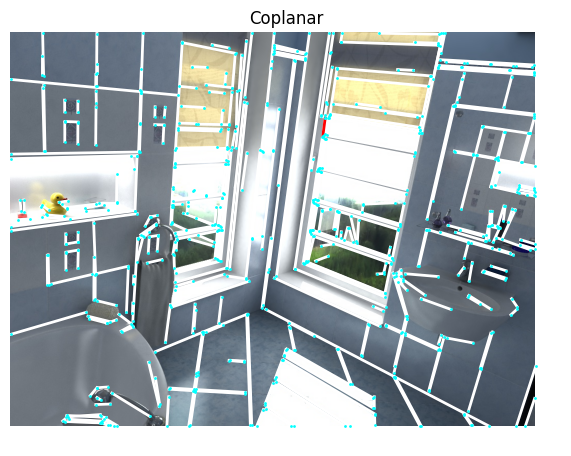

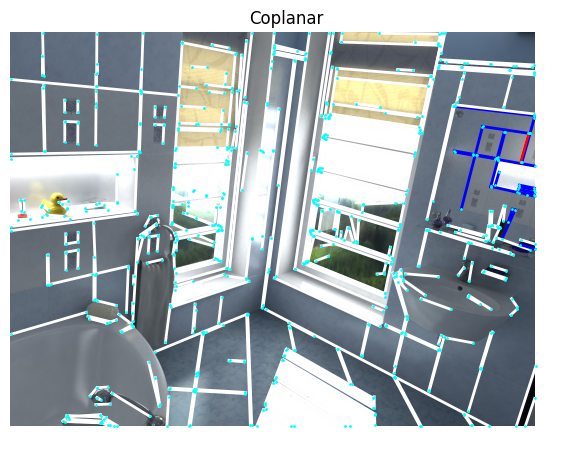

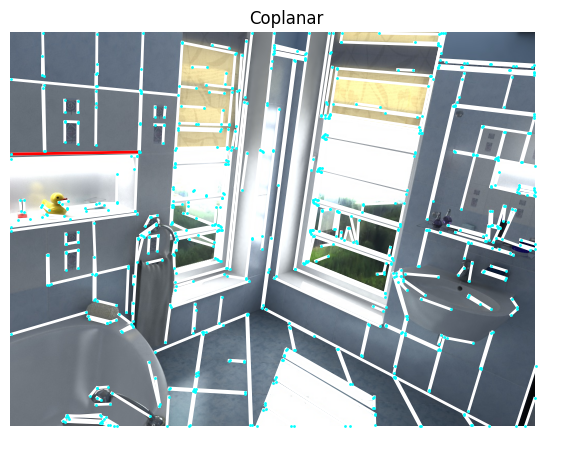

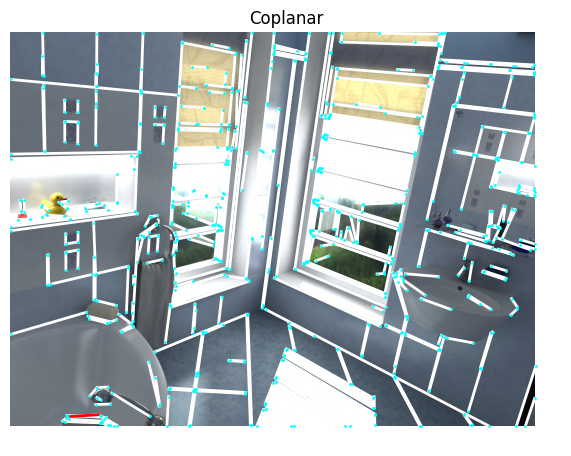

In [4]:
#Plot function
def plot_lines_struct(lines, coplanar_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'white' for struct in coplanar_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)

#Plot for a couple lines
for i in range(20,35):
    plot_images([img], ['Coplanar'], cmaps='gray')

    plot_lines_struct([pred_lines], coplanar_dict[i], indices=range(1))
    plot_lines([pred_lines[max(i, 0):i+1]], "red",indices=range(1))